In [32]:
"""Volume 2: Non-negative Matrix Factorization."""

import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
import os
from imageio import imread
import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error as mse

from itertools import combinations

In [87]:
#Problems 1-2
class NMFRecommender:

    def __init__(self,random_state=15,rank=3,maxiter=200,tol=1e-3):
        """The parameter values for the algorithm"""
        self.random_state = random_state
        self.rank = rank
        self.maxiter = maxiter
        self.tol = tol
        
    
    def initialize_matrices(self,m,n):
        """randomly initialize the W and H matrices,"""
        rs = np.random.seed(self.random_state)
        self.W = np.random.randint(2,size=(m,self.rank))
        self.H = np.random.randint(2,size=(self.rank,n))
        return self.W, self.H

      
    def fit(self,V):
        """Fits W and H weight matrices using CVXPY"""
        for _ in range(self.maxiter):
            # Solve for W with fixed H (updated each iteration)
            w = cp.Variable(self.W.shape,nonneg=True)
            objectiveW = cp.Minimize(cp.atoms.norm(V-w@self.H,p='fro'))
            probW = cp.Problem(objectiveW)
            probW.solve()
            
            # Update the W approximation
            self.W = w.value
            
            # Solve for H with fixed W (updated)
            h = cp.Variable(self.H.shape,nonneg=True)
            objectiveH = cp.Minimize(cp.atoms.norm(V-self.W@h,p='fro'))
            probH = cp.Problem(objectiveH)
            probH.solve()
            
            # Update the H approximation
            self.H = h.value
            
            # Check if (V - WH) is within tolerance
            if np.linalg.norm(V- self.W @ self.H,ord='fro') < self.tol:
                break

    def reconstruct(self):
        """Reconstruct V matrix for comparison against the original V"""
        return self.W @ self.H


In [103]:
def prob3():
    """Run NMF recommender on the grocery store example"""
    V = np.array(
        [
            [0, 1, 0, 1, 2, 2],
            [2, 3, 1, 1 ,2, 2],
            [1, 1, 1, 0, 1, 1],
            [0, 2, 3, 4, 1, 1],
            [0, 0, 0, 0, 1, 0]
        ]
    )
    
    foodRecommend = NMFRecommender(rank=2)
    foodRecommend.initialize_matrices(5,6)
    foodRecommend.fit(V)
    W, H = foodRecommend.W, foodRecommend.H
    
    # Find number of people with higher weights in component 2 than 1
    numGreater = 0
    for i in range(len(H[0])):
        if H[1,i] > H[0,i]:
            numGreater += 1
            
    return W, H, numGreater

In [111]:

#get data
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory.
    Flatten and convert each image to grayscale.

    Parameters:
        path (str): The directory containing the dataset of images.

    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)

def show(image, m=200, n=180, plt_show=False):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.

    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
        plt_show (bool): if True, call plt.show() at the end
    """
    #scale image
    image = image / 255
    #reshape image
    image = np.reshape(image,(m,n))
    #show image
    plt.imshow(image,cmap = "gray")
    
    if plt_show:
        plt.show()


In [161]:
def prob4():
    """
        Gridsearch over rank, alpha and l1_ratio values to reconstruct 
        image using NMF. Plot all reconstructed images.
    """
    
    faceData = get_faces()
    
    alphaVals = [0,.2,.5]
    l1Vals = [0,1e-5,10]
    WData = []
    HData = []
    reconstImages = []
    titleTuples = []
    
    # use NMF on each combination of rank, alpha, and l1_ratio values
    for a in alphaVals:
        for l in l1Vals:
            model = NMF(n_components=75,max_iter=200,alpha=a,l1_ratio=l)
            W = model.fit_transform(faceData)
            H = model.components_
            WData.append(W)
            HData.append(H)
            reconstImages.append(W@H)
            titleTuples.append((a,l))
            
    # plot the third images
    plt.subplots_adjust(wspace = .1,hspace = 10.)
    plt.figure(figsize=(20, 8))
    plt.tight_layout()
    for index, image in enumerate(reconstImages):
        plt.subplot(2,5,index+1)
        plt.title("n=75, "+"alpha="+str(titleTuples[index][0])+", l1_ratio="+str(titleTuples[index][1]))
        show(image[:,2])

    plt.show()

In [164]:
def prob5():
    '''
        find the 10 basis faces with the largest coefficients 
        corresponding to the the second and twelfth face in the dataset. 
        Plot these basis faces along with the original image using 
        subplots
    '''
    faceData = get_faces()
    
    model = NMF(n_components=75,max_iter=200,alpha=.5,l1_ratio=1e-5)        # Use NMF with best parameters from prob4()
    W = model.fit_transform(faceData)
    H = model.components_
    
    # analyze the 10 largest component of face 2 and 12
    comp2 = np.argsort(H[:,1])[-10:]
    comp12 = np.argsort(H[:,11])[-10:]
    
    
    plt.subplots_adjust(wspace = .1,hspace = 10.)
    plt.figure(figsize=(20, 8))
    plt.tight_layout()
    
    plt.subplot(4,6,1)
    show(faceData[:,1])
    plt.title("Original 2nd Face")
    plt.xticks([], [])
    plt.yticks([],[])
    
    for i,faceIndex in enumerate(comp2):
        plt.subplot(4,6,i+2)
        show(W[:,faceIndex])
        plt.xticks([], [])
        plt.yticks([],[])
        
    plt.subplot(4,6,13)
    show(faceData[:,11])
    plt.title("Original 12th Face")
    plt.xticks([], [])
    plt.yticks([],[])
        
    for i,faceIndex in enumerate(comp12):
        plt.subplot(4,6,i+14)
        show(W[:,faceIndex])
        plt.xticks([], [])
        plt.yticks([],[])
    
    plt.show()

<Figure size 432x288 with 0 Axes>

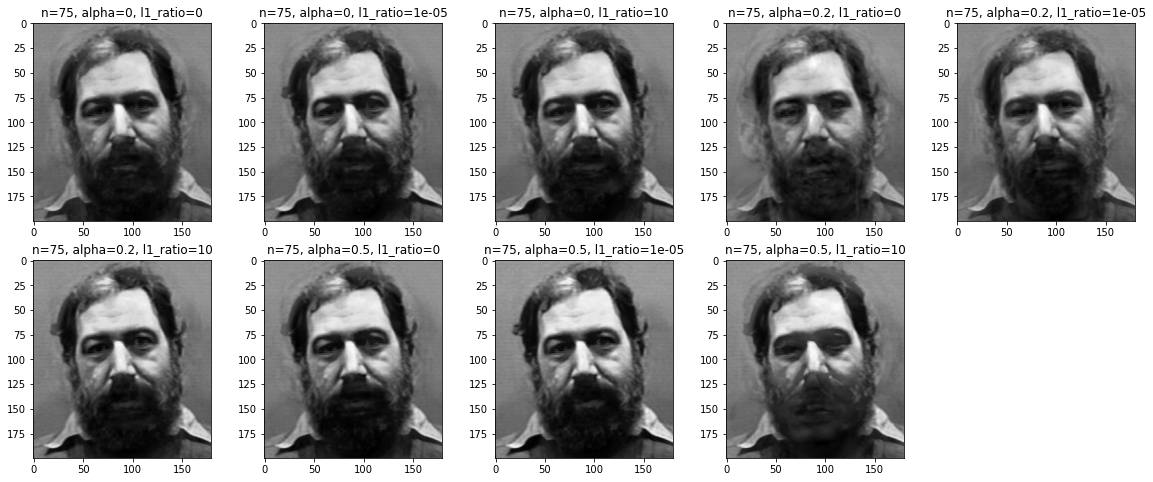

In [163]:
prob4()

<Figure size 432x288 with 0 Axes>

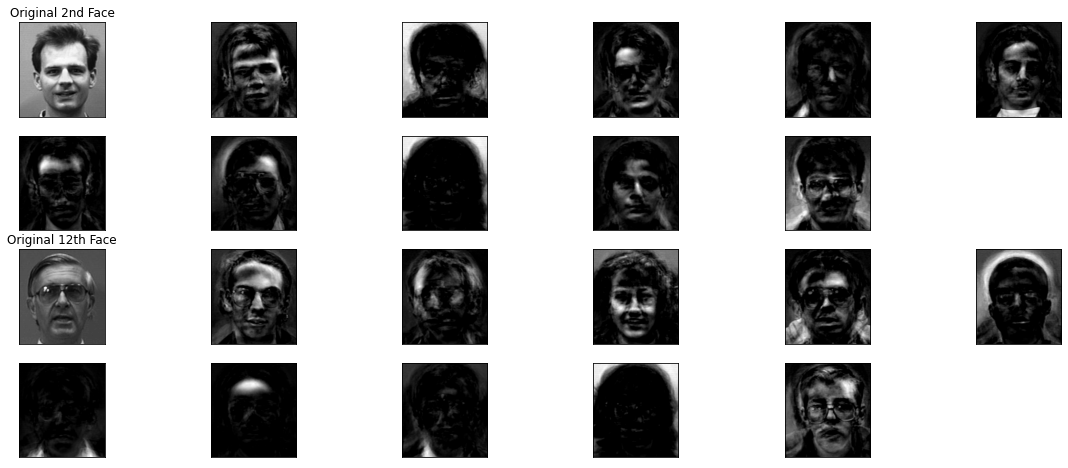

In [166]:
prob5()

Some difference I noticed in the basis faces is that some resemeble the original images head shape while other basis faces resemble the original image on details like glasses, nose shape, etc. Some basis faces look like actual people while other basis faces simply look like silhouettes.